In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

plt.style.use("default")


In [2]:
#LOAD THE SURVEY DATA AND LOGISTIC DATA
survey_df = pd.read_csv("survey_result.csv")
log_df    = pd.read_csv("logistics_dataset.csv")

print("Original columns:")
for c in survey_df.columns:
    print(repr(c))  # show exact text including \n



Original columns:
'Timestamp'
'1. How often do you shop online (Amazon, eBay, Zalando, etc.)?\n'
'Which delivery or logistics company most often handles your orders?'
'Where are you based'
'How long does it usually take for your online orders to arrive after purchase?'
'How satisfied are you with the delivery speed of your recent orders?\n(1 = Very Dissatisfied, 5 = Very Satisfied)\n'
'How often have you experienced late deliveries in the last 6 months?\n'
'When your delivery was late, what do you think was the most likely reason?\n'
'How often do your orders arrive with missing or incorrect items? E.g wrong size, wrong quantity or color'
'How satisfied are you with the condition of your packages when they arrive?\n(1 = Very Dissatisfied, 5 = Very Satisfied)\n'
'Do you believe warehouse and delivery staff have enough resources to handle large order volumes efficiently?\n'
'Which factor is most important to you when it comes to online order delivery?\n'
'Would you support the use of dat

In [3]:
# Preview the first few rows 
print("\nFIRST 5 ROWS:")
print(survey_df.head())


FIRST 5 ROWS:
                     Timestamp  \
0  2025/10/27 1:56:08 PM GMT+1   
1  2025/10/27 2:23:32 PM GMT+1   
2  2025/10/27 2:28:55 PM GMT+1   
3  2025/10/27 2:33:35 PM GMT+1   
4  2025/10/27 4:57:00 PM GMT+1   

  1. How often do you shop online (Amazon, eBay, Zalando, etc.)?\n  \
0                                             Weekly                 
1                                             Rarely                 
2                                             Rarely                 
3                                             Rarely                 
4                                I Don’t Shop Online                 

  Which delivery or logistics company most often handles your orders?  \
0                                                DHL                    
1                                                DHL                    
2                                                DHL                    
3                                                DHL               

In [4]:
# Descriptive info
print("\n DATA INFO:")
print(survey_df.info())


 DATA INFO:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 15 columns):
 #   Column                                                                                                                                                                                         Non-Null Count  Dtype 
---  ------                                                                                                                                                                                         --------------  ----- 
 0   Timestamp                                                                                                                                                                                      10 non-null     object
 1   1. How often do you shop online (Amazon, eBay, Zalando, etc.)?
                                                                                                                                10 non-null     object
 2   Whic

In [5]:
#RENAME COLUMNS USING THE EXACT QUESTION TEXT
rename_map = {
    "1. How often do you shop online (Amazon, eBay, Zalando, etc.)?\n": "delivery_frequency",
    "Which delivery or logistics company most often handles your orders?": "most_used_provider",
    "Where are you based": "location_region",
    "How long does it usually take for your online orders to arrive after purchase?": "perceived_delivery_time",
    "How satisfied are you with the delivery speed of your recent orders?\n(1 = Very Dissatisfied, 5 = Very Satisfied)\n": "delivery_speed_satisfaction",
    "How often have you experienced late deliveries in the last 6 months?\n": "delay_experience",
    "When your delivery was late, what do you think was the most likely reason?\n": "late_reason",
    "How often do your orders arrive with missing or incorrect items? E.g wrong size, wrong quantity or color": "wrong_item_frequency",
    "How satisfied are you with the condition of your packages when they arrive?\n(1 = Very Dissatisfied, 5 = Very Satisfied)\n": "package_condition",
    "Do you believe warehouse and delivery staff have enough resources to handle large order volumes efficiently?\n": "enough_resources",
    "Which factor is most important to you when it comes to online order delivery?\n": "priority_factor",
    "Would you support the use of data analytics or AI if it made deliveries faster and more accurate?\n": "ai_support",
    "What improvements would you like to see in online order delivery services?\n": "preferred_improvement",
    "Your responses are anonymous and will be used only for academic research at BSBI. By submitting this form, you consent to your answers being analyzed in aggregate for educational purposes.\n": "consent_text"}


survey_df = survey_df.rename(columns=rename_map)

print("\nRenamed columns:")
print(survey_df.columns.tolist())


Renamed columns:
['Timestamp', 'delivery_frequency', 'most_used_provider', 'location_region', 'perceived_delivery_time', 'delivery_speed_satisfaction', 'delay_experience', 'late_reason', 'wrong_item_frequency', 'package_condition', 'enough_resources', 'priority_factor', 'ai_support', 'preferred_improvement', 'consent_text']


In [6]:
#MAKE LIKERT COLUMNS NUMERIC
for col in ["delivery_speed_satisfaction", "package_condition"]:
    if col in survey_df.columns:
        survey_df[col] = pd.to_numeric(survey_df[col], errors="coerce")

#map delay_experience into a numeric order
delay_map = {
    "Never": 0,
    "Rarely": 1,
    "Sometimes": 2,
    "Often": 3,
    "Very often": 4
}
if "delay_experience" in survey_df.columns:
    survey_df["delay_experience_num"] = survey_df["delay_experience"].map(delay_map)

In [7]:
#MEAN SATISFACTION BY PROVIDER
print("\n=== Mean delivery-speed satisfaction by provider ===")
if {"most_used_provider", "delivery_speed_satisfaction"}.issubset(survey_df.columns):
    provider_satisfaction = (
        survey_df
        .groupby("most_used_provider")["delivery_speed_satisfaction"]
        .mean()
        .sort_values(ascending=False)
    )
    print(provider_satisfaction)
else:
    print("Required columns not found for provider analysis.")



=== Mean delivery-speed satisfaction by provider ===
most_used_provider
DHL                 3.75
Amazon Logistics    3.00
Hermes              1.00
Name: delivery_speed_satisfaction, dtype: float64


In [8]:
# MEAN SATISFACTION BY REGION
print("\n=== Mean delivery-speed satisfaction by region ===")
if {"location_region", "delivery_speed_satisfaction"}.issubset(survey_df.columns):
    region_satisfaction = (
        survey_df
        .groupby("location_region")["delivery_speed_satisfaction"]
        .mean()
        .sort_values(ascending=False)
    )
    print(region_satisfaction)
else:
    print("Required columns not found for region analysis.")



=== Mean delivery-speed satisfaction by region ===
location_region
Other parts of Germany    3.5
Outside Germany           3.5
Berlin                    3.0
Name: delivery_speed_satisfaction, dtype: float64


In [9]:
#CROSSTAB: DELAY EXPERIENCE × SATISFACTION
print("\n=== Row-normalised satisfaction within each delay category ===")
if {"delay_experience", "delivery_speed_satisfaction"}.issubset(survey_df.columns):
    delay_sat_crosstab = pd.crosstab(
        survey_df["delay_experience"],
        survey_df["delivery_speed_satisfaction"],
        normalize="index"
    )
    print(delay_sat_crosstab.round(3))
else:
    print("Required columns not found for delay × satisfaction crosstab.")



=== Row-normalised satisfaction within each delay category ===
delivery_speed_satisfaction     1     3     4    5
delay_experience                                  
Never                        0.00  0.50  0.00  0.5
Rarely                       0.00  0.25  0.75  0.0
Sometimes                    0.25  0.50  0.25  0.0


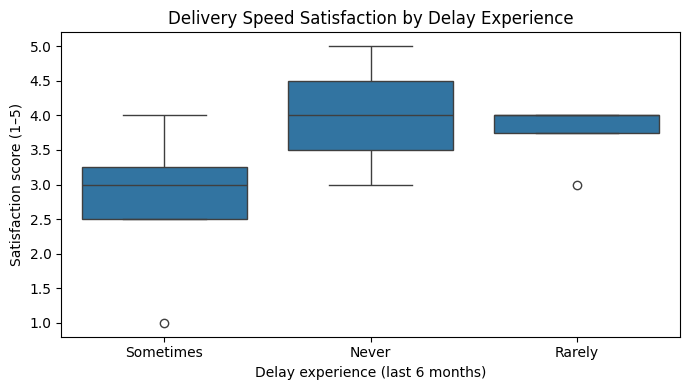

In [10]:
#BOX PLOT: SATISFACTION BY DELAY EXPERIENCE
if {"delay_experience", "delivery_speed_satisfaction"}.issubset(survey_df.columns):
    plt.figure(figsize=(7, 4))
    sns.boxplot(
        x="delay_experience",
        y="delivery_speed_satisfaction",
        data=survey_df
    )
    plt.title("Delivery Speed Satisfaction by Delay Experience")
    plt.xlabel("Delay experience (last 6 months)")
    plt.ylabel("Satisfaction score (1–5)")
    plt.tight_layout()
    plt.show()
else:
    print("\nCannot draw boxplot – needed columns missing.")


In [11]:
#FREQUENCY TABLES FOR KEY CATEGORICAL VARIABLES
categorical_vars = [
    "delivery_frequency",
    "delay_experience",
    "most_used_provider",
    "ai_support",
    "preferred_improvement",
    "location_region"
]

print("\n=== Frequency tables for key survey variables ===")
for col in categorical_vars:
    if col in survey_df.columns:
        print(f"\nColumn: {col}")
        print(survey_df[col].value_counts())
    else:
        print(f"\nColumn '{col}' not found in DataFrame.")


=== Frequency tables for key survey variables ===

Column: delivery_frequency
delivery_frequency
Rarely                 5
Weekly                 4
I Don’t Shop Online    1
Name: count, dtype: int64

Column: delay_experience
delay_experience
Sometimes    4
Rarely       4
Never        2
Name: count, dtype: int64

Column: most_used_provider
most_used_provider
DHL                 8
Amazon Logistics    1
Hermes              1
Name: count, dtype: int64

Column: ai_support
ai_support
Yes    10
Name: count, dtype: int64

Column: preferred_improvement
preferred_improvement
I haven’t thought about this.                                                               1
More tracking and communication                                                             1
No delay                                                                                    1
Accuracy and speed with improved tracking                                                   1
Want to see improvement in speed and Accuracy with e

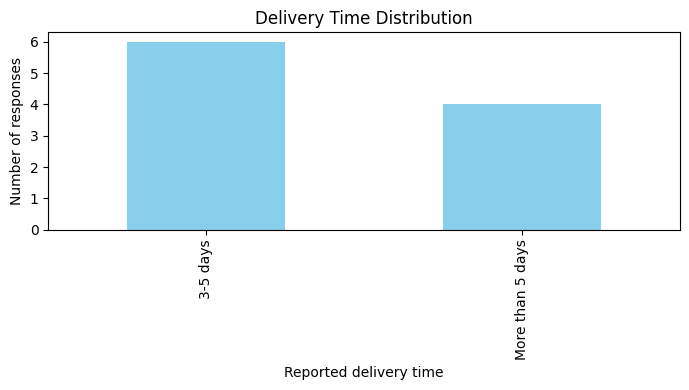

In [12]:
# DELIVERY TIME DISTRIBUTION
plt.figure(figsize=(7, 4))
survey_df["perceived_delivery_time"].value_counts().plot(
    kind="bar",
    color="skyblue"
)
plt.title("Delivery Time Distribution")
plt.xlabel("Reported delivery time")
plt.ylabel("Number of responses")
plt.tight_layout()
plt.savefig("delivery_time_distribution.png")
plt.show()



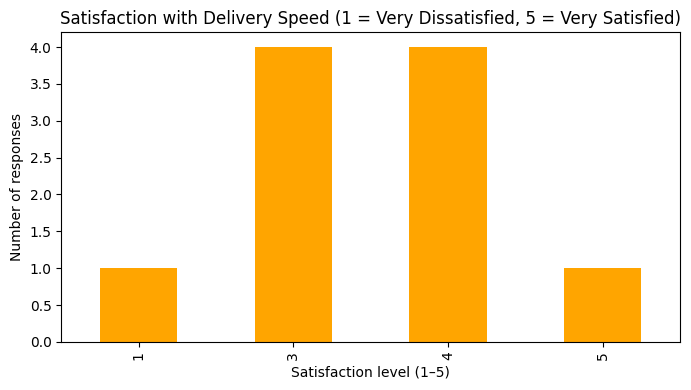

In [13]:
# SATISFACTION WITH DELIVERY SPEED
plt.figure(figsize=(7, 4))
survey_df["delivery_speed_satisfaction"].value_counts().sort_index().plot(
    kind="bar",
    color="orange"
)
plt.title("Satisfaction with Delivery Speed (1 = Very Dissatisfied, 5 = Very Satisfied)")
plt.xlabel("Satisfaction level (1–5)")
plt.ylabel("Number of responses")
plt.tight_layout()
plt.savefig("speed_satisfaction.png")
plt.show()

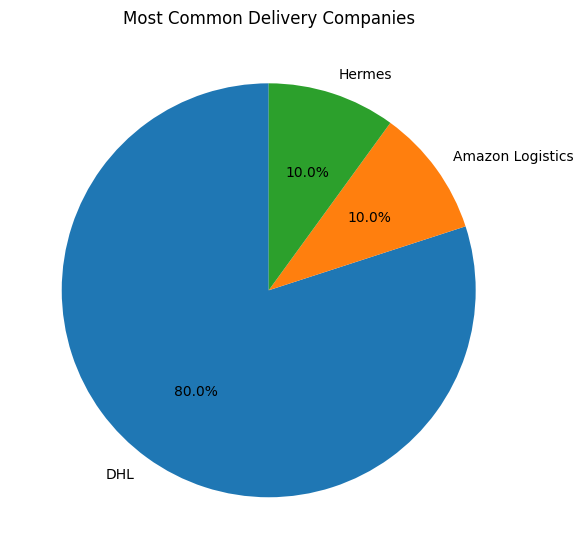

In [14]:
# MOST USED DELIVERY COMPANY
plt.figure(figsize=(6, 6))
survey_df["most_used_provider"].value_counts().plot(
    kind="pie",
    autopct="%1.1f%%",
    startangle=90
)
plt.title("Most Common Delivery Companies")
plt.ylabel("")
plt.tight_layout()
plt.savefig("delivery_companies_pie.png")
plt.show()


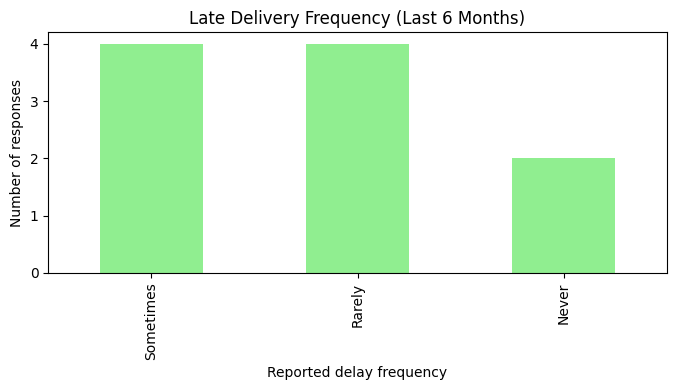

In [15]:
# LATE DELIVERIES FREQUENCY
plt.figure(figsize=(7, 4))
survey_df["delay_experience"].value_counts().plot(
    kind="bar",
    color="lightgreen"
)
plt.title("Late Delivery Frequency (Last 6 Months)")
plt.xlabel("Reported delay frequency")
plt.ylabel("Number of responses")
plt.tight_layout()
plt.savefig("late_frequency.png")
plt.show()

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [17]:
 #LOAD LOGISTIC DATA
log_df = pd.read_csv("logistics_dataset.csv")

print("FIRST 5 ROWS")
print(log_df.head())

print("\nCOLUMN NAMES")
print(log_df.columns.tolist())



FIRST 5 ROWS
    item_id    category  stock_level  reorder_point  reorder_frequency_days  \
0  ITM10000      Pharma          283             21                       4   
1  ITM10001  Automotive          301             52                       9   
2  ITM10002   Groceries          132             60                      11   
3  ITM10003  Automotive          346             46                      13   
4  ITM10004  Automotive           49             55                       4   

   lead_time_days  daily_demand  demand_std_dev  item_popularity_score  \
0               4         49.85            1.56                   0.43   
1               6         23.34            2.55                   0.69   
2               8         37.69            3.15                   0.62   
3               5         33.69            2.79                   0.21   
4               6         49.58            5.23                   0.31   

  storage_location_id  ... unit_price  holding_cost_per_unit_day  \

In [18]:
#NUMERICAL ANALYSIS (DESCRIPTIVE STATISTICS)
print("\n===== NUMERICAL SUMMARY =====")
print(log_df.describe())



===== NUMERICAL SUMMARY =====
       stock_level  reorder_point  reorder_frequency_days  lead_time_days  \
count  3204.000000    3204.000000             3204.000000     3204.000000   
mean    263.491573      54.759363                8.507803        5.578340   
std     138.568360      26.053354                3.473229        2.292486   
min      20.000000      10.000000                3.000000        2.000000   
25%     144.000000      32.000000                5.000000        4.000000   
50%     264.000000      55.000000                9.000000        6.000000   
75%     386.000000      78.000000               12.000000        8.000000   
max     499.000000      99.000000               14.000000        9.000000   

       daily_demand  demand_std_dev  item_popularity_score  \
count   3204.000000     3204.000000            3204.000000   
mean      25.435868        5.260078               0.542325   
std       14.038861        2.725639               0.259200   
min        1.010000        

In [19]:
# Identify numeric columns
numeric_cols = log_df.select_dtypes(include=[np.number]).columns.tolist()
print("\nNumeric Columns Detected:", numeric_cols)


Numeric Columns Detected: ['stock_level', 'reorder_point', 'reorder_frequency_days', 'lead_time_days', 'daily_demand', 'demand_std_dev', 'item_popularity_score', 'picking_time_seconds', 'handling_cost_per_unit', 'unit_price', 'holding_cost_per_unit_day', 'stockout_count_last_month', 'order_fulfillment_rate', 'total_orders_last_month', 'turnover_ratio', 'layout_efficiency_score', 'forecasted_demand_next_7d', 'KPI_score']


In [20]:
# DATA CLEANING
print("\nDATA CLEANING")
print("Initial shape:", log_df.shape)


DATA CLEANING
Initial shape: (3204, 23)


In [21]:
# Remove duplicates
log_df = log_df.drop_duplicates()

In [22]:
# Handle missing values: fill numeric with mean, categorical with mode
for col in log_df.columns:
    if log_df[col].dtype == "object":
        log_df[col] = log_df[col].fillna(log_df[col].mode()[0])
    else:
        log_df[col] = log_df[col].fillna(log_df[col].mean())

print("After handling missing values:", log_df.isnull().sum().sum(), "missing values remaining")
print("After removing duplicates:", log_df.shape)

After handling missing values: 0 missing values remaining
After removing duplicates: (3204, 23)


In [23]:
#WAREHOUSE VARIABLES – DESCRIPTIVE TABLES
# Key operational variables
op_vars = [
    "stock_level",
    "reorder_frequency_days",
    "lead_time_days",
    "handling_cost_per_unit",
    "picking_time_seconds",
    "turnover_ratio",
    "KPI_score"
]

existing_op_vars = [c for c in op_vars if c in log_df.columns]

op_summary = log_df[existing_op_vars].agg(["mean", "std", "min", "max"]).T
op_summary = op_summary.rename(columns={
    "mean": "Mean",
    "std": "Std_Dev",
    "min": "Min",
    "max": "Max"
})

print("\n=== Summary of key operational variables (Mean, Std, Min, Max) ===")
print(op_summary.round(3))



=== Summary of key operational variables (Mean, Std, Min, Max) ===
                           Mean  Std_Dev     Min      Max
stock_level             263.492  138.568  20.000  499.000
reorder_frequency_days    8.508    3.473   3.000   14.000
lead_time_days            5.578    2.292   2.000    9.000
handling_cost_per_unit    2.777    1.305   0.500    5.000
picking_time_seconds     95.606   49.218  10.000  179.000
turnover_ratio            8.124    4.069   1.000   15.000
KPI_score                 0.602    0.108   0.259    0.936


In [24]:
#CORRELATION ANALYSIS FOCUSED ON LEAD TIME

if "lead_time_days" in log_df.columns:
    corr_with_lead = (
        log_df[existing_op_vars]
        .corr()["lead_time_days"]
        .sort_values(ascending=False)
    )
    print("\nCorrelation of operational variables with lead_time_days:")
    print(corr_with_lead.round(3))
else:
    print("\n'lead_time_days' not found in warehouse dataset.")


Correlation of operational variables with lead_time_days:
lead_time_days            1.000
KPI_score                 0.025
reorder_frequency_days    0.015
handling_cost_per_unit    0.012
stock_level              -0.006
picking_time_seconds     -0.010
turnover_ratio           -0.018
Name: lead_time_days, dtype: float64


In [25]:
#PREDICTIVE MODELLING – STANDARDISED COEFFICIENTS
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

# Choose independent variables (only those that exist)
candidate_features = [
    "stock_level",
    "reorder_frequency_days",
    "handling_cost_per_unit",
    "picking_time_seconds",
    "turnover_ratio",
    "KPI_score"
]

features = [c for c in candidate_features if c in log_df.columns]

if "lead_time_days" in log_df.columns and len(features) > 0:
    # Keep only rows with no missing values in selected features + target
    model_data = log_df[features + ["lead_time_days"]].dropna()

    X = model_data[features]
    y = model_data["lead_time_days"]

    # Standardise features so coefficients are comparable
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    reg = LinearRegression()
    reg.fit(X_scaled, y)

    coef_table = pd.DataFrame({
        "feature": features,
        "standardised_coefficient": reg.coef_
    }).sort_values(
        "standardised_coefficient",
        key=lambda x: x.abs(),  # sort by absolute impact
        ascending=False
    )

    print("\n=== Standardised regression coefficients (influence on lead_time_days) ===")
    print(coef_table.round(4))

else:
    print("\nCannot run regression: missing 'lead_time_days' or no valid feature columns.")


=== Standardised regression coefficients (influence on lead_time_days) ===
                  feature  standardised_coefficient
5               KPI_score                    0.1044
4          turnover_ratio                   -0.0928
1  reorder_frequency_days                    0.0343
2  handling_cost_per_unit                    0.0312
3    picking_time_seconds                   -0.0233
0             stock_level                   -0.0149


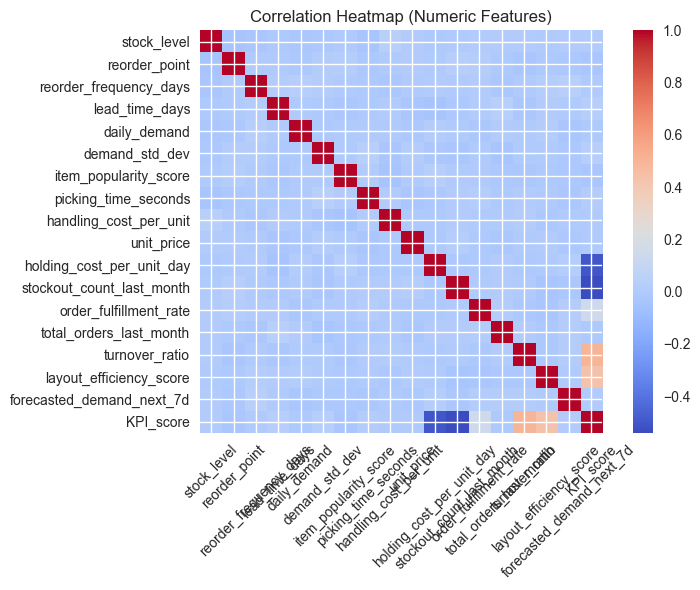

In [26]:
#VISUALIZATIONS
plt.style.use("seaborn-v0_8")

#Correlation heatmap
plt.figure(figsize=(8, 6))
corr = log_df[numeric_cols].corr()
plt.imshow(corr, cmap="coolwarm", interpolation="nearest")
plt.title("Correlation Heatmap (Numeric Features)")
plt.xticks(range(len(corr)), corr.columns, rotation=45)
plt.yticks(range(len(corr)), corr.columns)
plt.colorbar()
plt.tight_layout()
plt.savefig("logistics_correlation_heatmap.png")
plt.show()


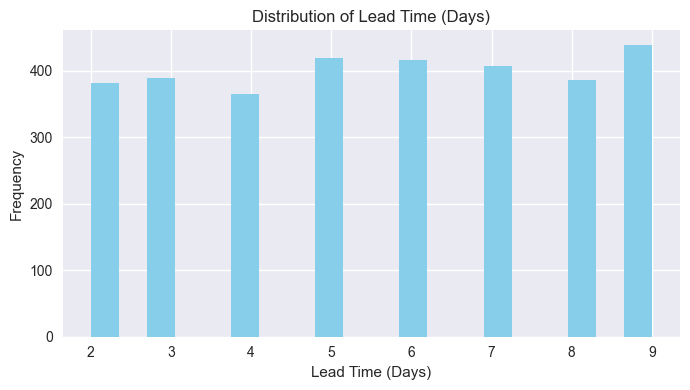

In [27]:
# Histogram: Lead Time
if "lead_time_days" in log_df.columns:
    plt.figure(figsize=(7, 4))
    log_df["lead_time_days"].hist(bins=20, color="skyblue")
    plt.title("Distribution of Lead Time (Days)")
    plt.xlabel("Lead Time (Days)")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.savefig("lead_time_hist.png")
    plt.show()


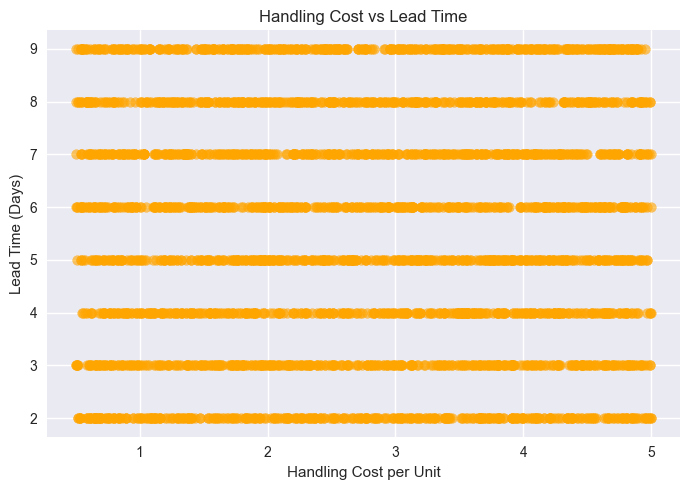

In [28]:
# Scatter: Handling cost vs Lead Time
if {"handling_cost_per_unit", "lead_time_days"}.issubset(log_df.columns):
    plt.figure(figsize=(7, 5))
    plt.scatter(log_df["handling_cost_per_unit"], log_df["lead_time_days"], color="orange", alpha=0.6)
    plt.title("Handling Cost vs Lead Time")
    plt.xlabel("Handling Cost per Unit")
    plt.ylabel("Lead Time (Days)")
    plt.tight_layout()
    plt.savefig("handling_cost_vs_lead_time.png")
    plt.show()

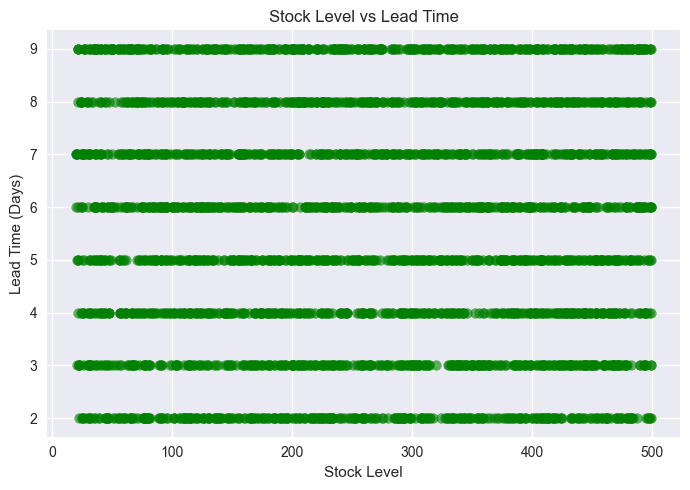

In [29]:
# Scatter: Stock Level vs Lead Time
if {"stock_level", "lead_time_days"}.issubset(log_df.columns):
    plt.figure(figsize=(7, 5))
    plt.scatter(log_df["stock_level"], log_df["lead_time_days"], color="green", alpha=0.6)
    plt.title("Stock Level vs Lead Time")
    plt.xlabel("Stock Level")
    plt.ylabel("Lead Time (Days)")
    plt.tight_layout()
    plt.savefig("stock_level_vs_lead_time.png")
    plt.show()

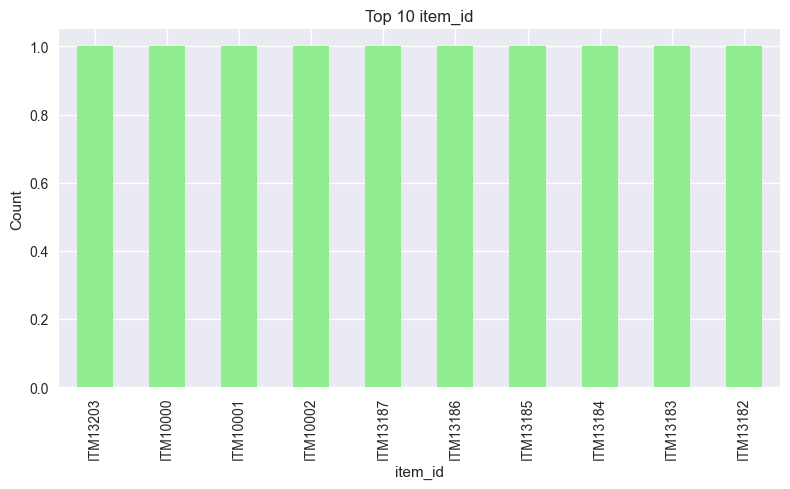

In [30]:
# Top 10 categories 
cat_cols = [
    c for c in log_df.columns
    if "category" in c.lower() or "product" in c.lower() or "item" in c.lower()
]
if cat_cols:
    cat_col = cat_cols[0]
    plt.figure(figsize=(8, 5))
    log_df[cat_col].value_counts().head(10).plot(kind="bar", color="lightgreen")
    plt.title(f"Top 10 {cat_col}")
    plt.xlabel(cat_col)
    plt.ylabel("Count")
    plt.tight_layout()
    plt.savefig("top10_categories.png")
    plt.show()


Mean delivery-speed satisfaction by provider:
most_used_provider
DHL                 3.75
Amazon Logistics    3.00
Hermes              1.00
Name: delivery_speed_satisfaction, dtype: float64


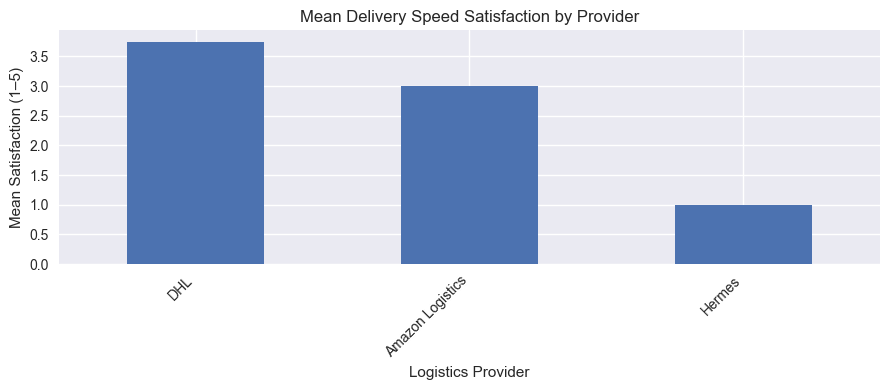

In [31]:
# Ensure satisfaction is numeric
survey_df["delivery_speed_satisfaction"] = pd.to_numeric(
    survey_df["delivery_speed_satisfaction"], errors="coerce"
)

provider_mean = (
    survey_df.groupby("most_used_provider")["delivery_speed_satisfaction"]
    .mean()
    .sort_values(ascending=False)
)

print("\nMean delivery-speed satisfaction by provider:")
print(provider_mean.round(2))

plt.figure(figsize=(9,4))
provider_mean.plot(kind="bar")
plt.title("Mean Delivery Speed Satisfaction by Provider")
plt.xlabel("Logistics Provider")
plt.ylabel("Mean Satisfaction (1–5)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.savefig("mean_satisfaction_by_provider.png")
plt.show()




Mean delivery-speed satisfaction by region:
location_region
Other parts of Germany    3.5
Outside Germany           3.5
Berlin                    3.0
Name: delivery_speed_satisfaction, dtype: float64


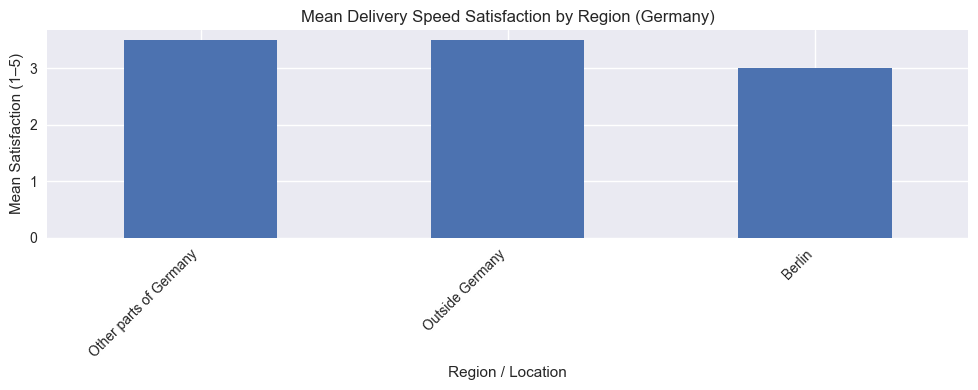

In [32]:
survey_df["delivery_speed_satisfaction"] = pd.to_numeric(
    survey_df["delivery_speed_satisfaction"], errors="coerce"
)

region_mean = (
    survey_df.groupby("location_region")["delivery_speed_satisfaction"]
    .mean()
    .sort_values(ascending=False)
)

print("\nMean delivery-speed satisfaction by region:")
print(region_mean.round(2))

plt.figure(figsize=(10,4))
region_mean.plot(kind="bar")
plt.title("Mean Delivery Speed Satisfaction by Region (Germany)")
plt.xlabel("Region / Location")
plt.ylabel("Mean Satisfaction (1–5)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.savefig("mean_satisfaction_by_region.png")
plt.show()


C:\Users\Victory\AppData\Local\Temp\ipykernel_15844\705998301.py:13: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([log_df[c].dropna() for c in op_vars], labels=op_vars, showfliers=True)


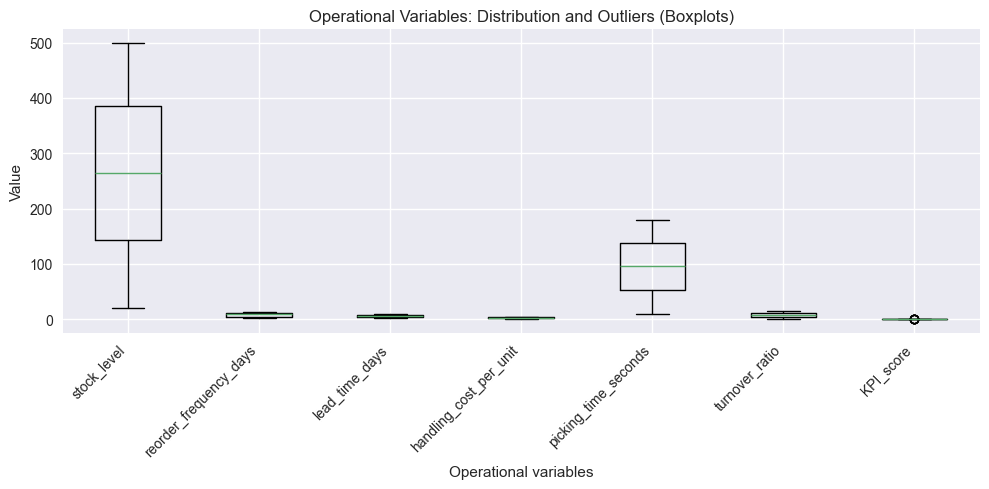

In [41]:
op_vars = [
    "stock_level",
    "reorder_frequency_days",
    "lead_time_days",
    "handling_cost_per_unit",
    "picking_time_seconds",
    "turnover_ratio",
    "KPI_score"
]
op_vars = [c for c in op_vars if c in log_df.columns]

plt.figure(figsize=(10, 5))
plt.boxplot([log_df[c].dropna() for c in op_vars], labels=op_vars, showfliers=True)
plt.title("Operational Variables: Distribution and Outliers (Boxplots)")
plt.xlabel("Operational variables")
plt.ylabel("Value")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.savefig("ch4_operational_boxplots.png")
plt.show()


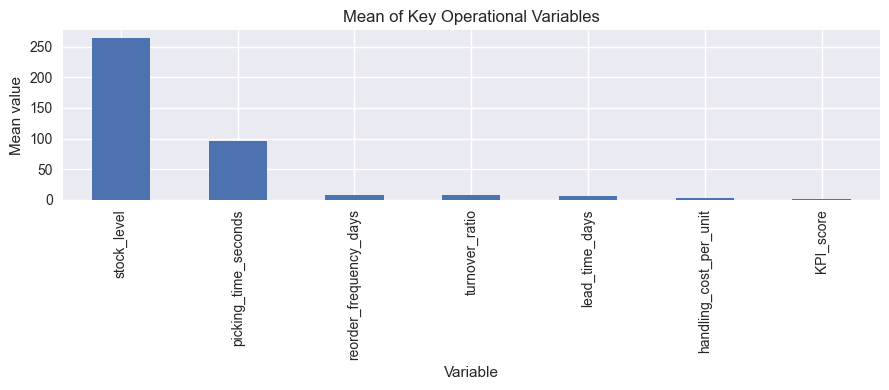

In [42]:
means = log_df[op_vars].mean(numeric_only=True).sort_values(ascending=False)

plt.figure(figsize=(9, 4))
means.plot(kind="bar")
plt.title("Mean of Key Operational Variables")
plt.xlabel("Variable")
plt.ylabel("Mean value")
plt.tight_layout()
plt.savefig("ch4_operational_means_bar.png")
plt.show()


C:\Users\Victory\AppData\Local\Temp\ipykernel_15844\131315333.py:12: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=top_cats, showfliers=True)


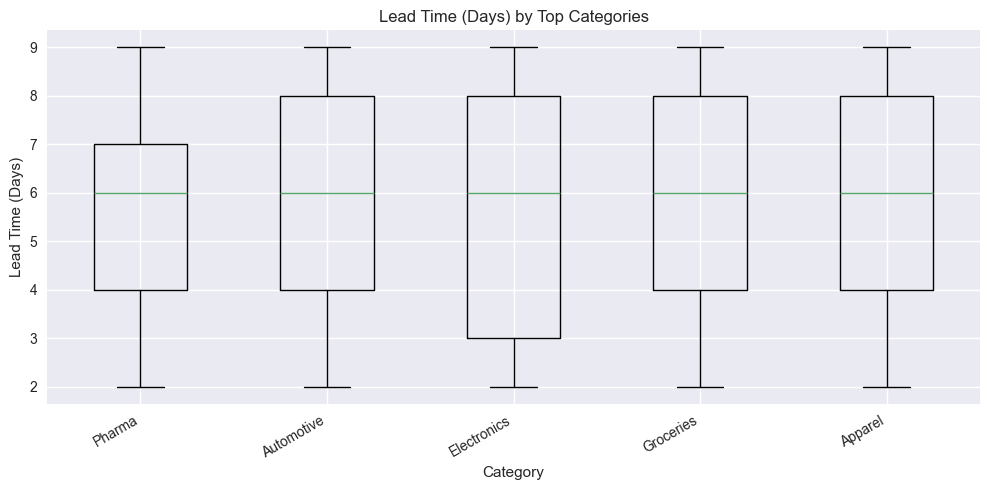

In [43]:
# Detect category column safely
cat_col = "category" if "category" in log_df.columns else None

if cat_col:
    top_cats = log_df[cat_col].value_counts().head(8).index
    subset = log_df[log_df[cat_col].isin(top_cats)]

    # Prepare data for boxplot
    data = [subset[subset[cat_col] == c]["lead_time_days"].dropna() for c in top_cats]

    plt.figure(figsize=(10, 5))
    plt.boxplot(data, labels=top_cats, showfliers=True)
    plt.title("Lead Time (Days) by Top Categories")
    plt.xlabel("Category")
    plt.ylabel("Lead Time (Days)")
    plt.xticks(rotation=30, ha="right")
    plt.tight_layout()
    plt.savefig("ch4_leadtime_by_category_box.png")
    plt.show()
else:
    print("No 'category' column found — skip lead time by category plot.")


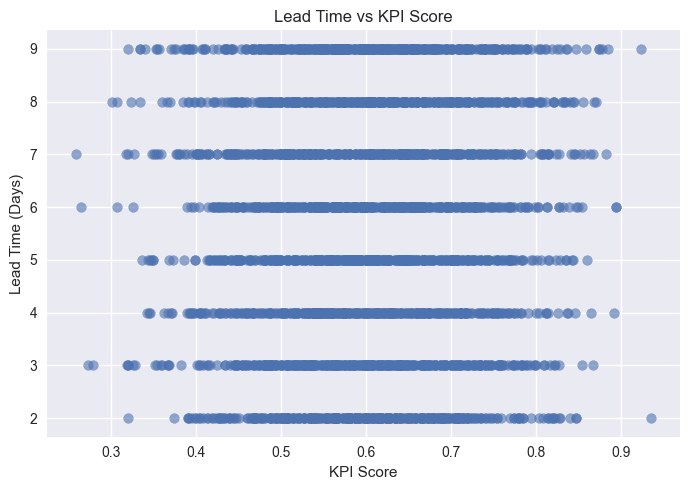

In [44]:
if {"lead_time_days", "KPI_score"}.issubset(log_df.columns):
    plt.figure(figsize=(7, 5))
    plt.scatter(log_df["KPI_score"], log_df["lead_time_days"], alpha=0.6)
    plt.title("Lead Time vs KPI Score")
    plt.xlabel("KPI Score")
    plt.ylabel("Lead Time (Days)")
    plt.tight_layout()
    plt.savefig("ch4_leadtime_vs_kpi_scatter.png")
    plt.show()
else:
    print("Missing columns for lead_time_days vs KPI_score scatter.")


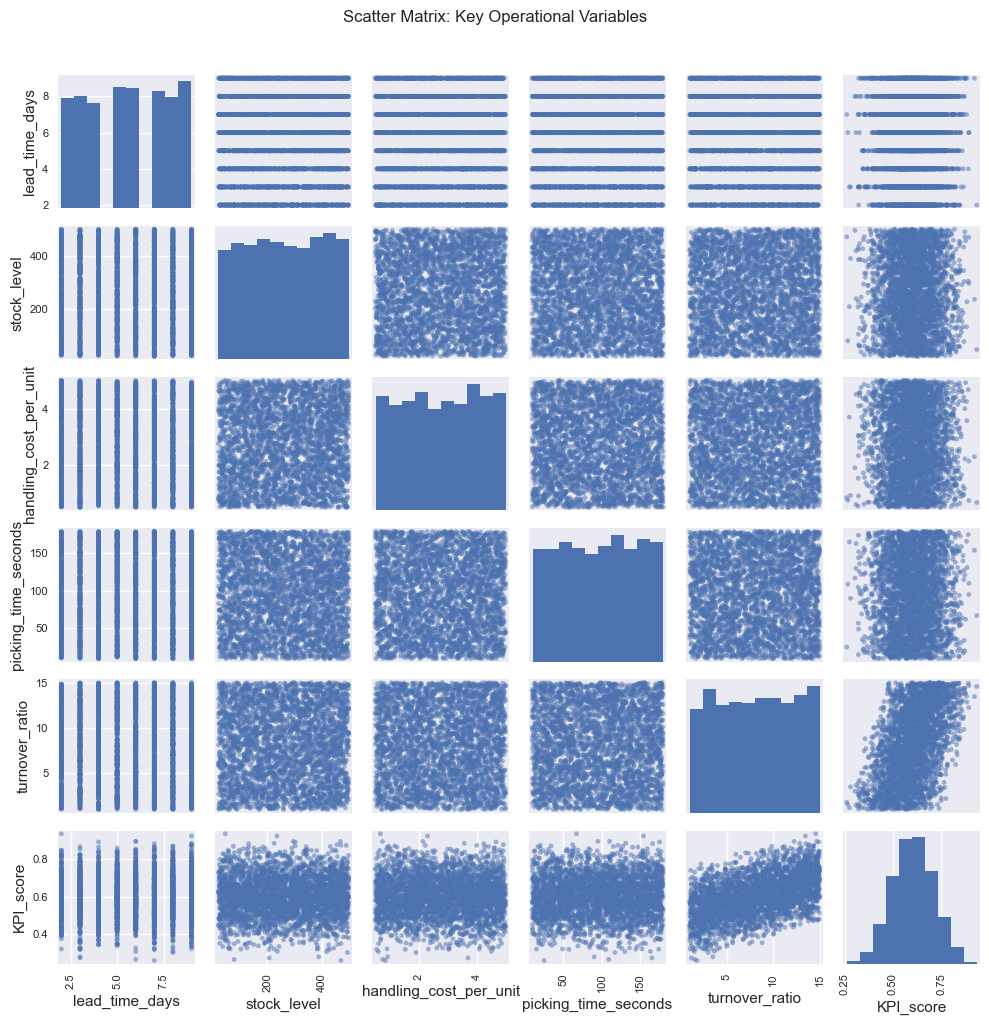

In [45]:
rel_vars = ["lead_time_days", "stock_level", "handling_cost_per_unit", "picking_time_seconds", "turnover_ratio", "KPI_score"]
rel_vars = [c for c in rel_vars if c in log_df.columns]

pd.plotting.scatter_matrix(
    log_df[rel_vars].dropna(),
    figsize=(10, 10),
    diagonal="hist",
)
plt.suptitle("Scatter Matrix: Key Operational Variables", y=1.02)
plt.tight_layout()
plt.savefig("ch4_scatter_matrix_operational.png")
plt.show()


In [33]:
survey_df["delivery_speed_satisfaction"] = pd.to_numeric(
    survey_df["delivery_speed_satisfaction"], errors="coerce"
)

ctab = pd.crosstab(
    survey_df["delay_experience"],
    survey_df["delivery_speed_satisfaction"],
    normalize="index"
).round(3)

print("\nRow-normalised crosstab (delay_experience x satisfaction):")
print(ctab)

ctab.to_csv("crosstab_delay_experience_vs_satisfaction.csv")



Row-normalised crosstab (delay_experience x satisfaction):
delivery_speed_satisfaction     1     3     4    5
delay_experience                                  
Never                        0.00  0.50  0.00  0.5
Rarely                       0.00  0.25  0.75  0.0
Sometimes                    0.25  0.50  0.25  0.0


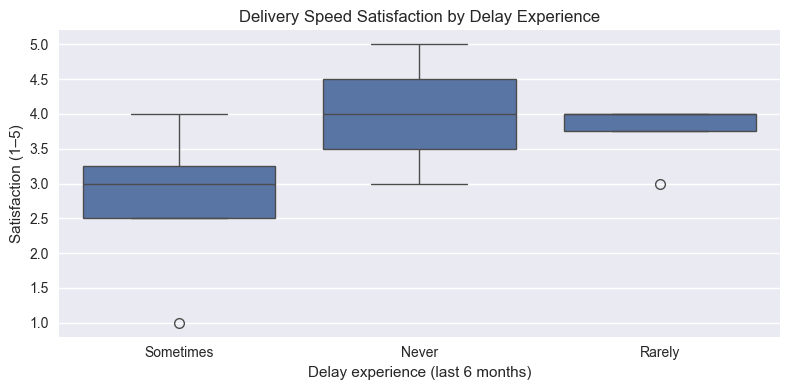

In [34]:
survey_df["delivery_speed_satisfaction"] = pd.to_numeric(
    survey_df["delivery_speed_satisfaction"], errors="coerce"
)

plt.figure(figsize=(8,4))
sns.boxplot(
    x="delay_experience",
    y="delivery_speed_satisfaction",
    data=survey_df,
    order=survey_df["delay_experience"].dropna().unique()
)
plt.title("Delivery Speed Satisfaction by Delay Experience")
plt.xlabel("Delay experience (last 6 months)")
plt.ylabel("Satisfaction (1–5)")
plt.tight_layout()
plt.savefig("boxplot_satisfaction_by_delay_experience.png")
plt.show()


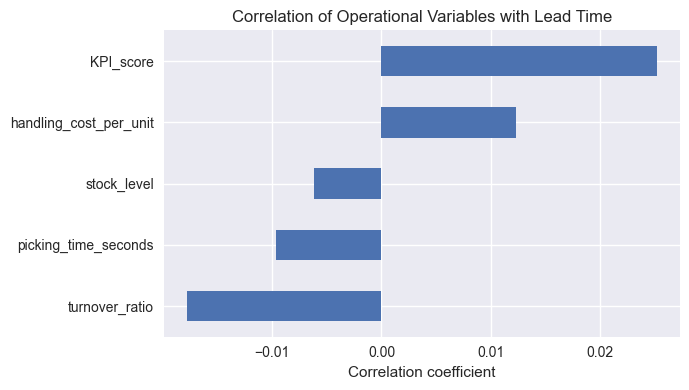

In [46]:
if "lead_time_days" in log_df.columns:
    corr = log_df[rel_vars].corr(numeric_only=True)["lead_time_days"].drop("lead_time_days").sort_values()

    plt.figure(figsize=(7, 4))
    corr.plot(kind="barh")
    plt.title("Correlation of Operational Variables with Lead Time")
    plt.xlabel("Correlation coefficient")
    plt.tight_layout()
    plt.savefig("ch4_corr_with_leadtime_bar.png")
    plt.show()
else:
    print("'lead_time_days' not found.")


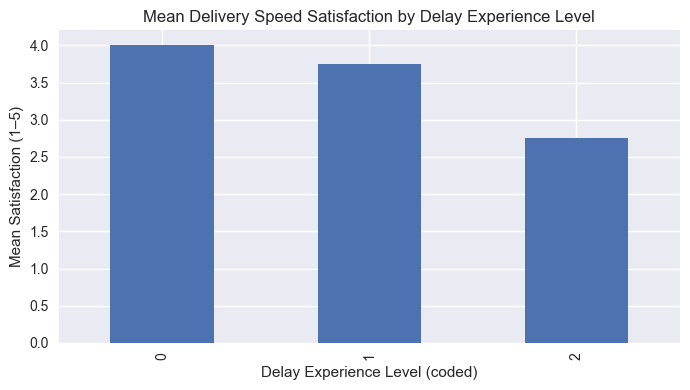

In [47]:
if {"delay_experience_num", "delivery_speed_satisfaction"}.issubset(survey_df.columns):
    # Convert to numeric safely
    survey_df["delivery_speed_satisfaction"] = pd.to_numeric(survey_df["delivery_speed_satisfaction"], errors="coerce")
    survey_df["delay_experience_num"] = pd.to_numeric(survey_df["delay_experience_num"], errors="coerce")

    grouped = survey_df.groupby("delay_experience_num")["delivery_speed_satisfaction"].mean().sort_index()

    plt.figure(figsize=(7, 4))
    grouped.plot(kind="bar")
    plt.title("Mean Delivery Speed Satisfaction by Delay Experience Level")
    plt.xlabel("Delay Experience Level (coded)")
    plt.ylabel("Mean Satisfaction (1–5)")
    plt.tight_layout()
    plt.savefig("ch4_mean_satisfaction_by_delaylevel.png")
    plt.show()
else:
    print("Missing delay_experience_num or delivery_speed_satisfaction columns.")


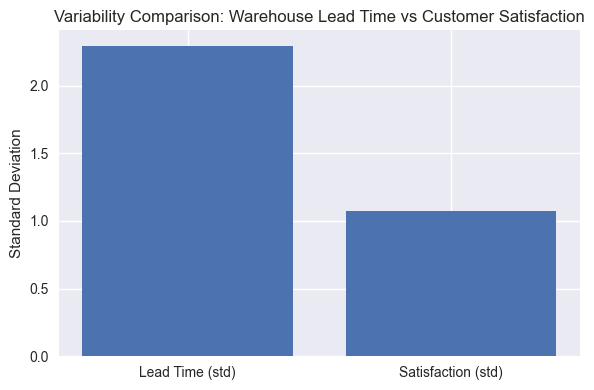

In [48]:
# Lead time variability (std dev)
lead_std = log_df["lead_time_days"].std() if "lead_time_days" in log_df.columns else None

# Satisfaction variability (std dev)
sat_std = None
if "delivery_speed_satisfaction" in survey_df.columns:
    survey_df["delivery_speed_satisfaction"] = pd.to_numeric(survey_df["delivery_speed_satisfaction"], errors="coerce")
    sat_std = survey_df["delivery_speed_satisfaction"].std()

if (lead_std is not None) and (sat_std is not None):
    plt.figure(figsize=(6, 4))
    plt.bar(["Lead Time (std)", "Satisfaction (std)"], [lead_std, sat_std])
    plt.title("Variability Comparison: Warehouse Lead Time vs Customer Satisfaction")
    plt.ylabel("Standard Deviation")
    plt.tight_layout()
    plt.savefig("ch4_variability_internal_external.png")
    plt.show()
else:
    print("Could not compute variability comparison (missing columns).")


In [35]:
target_col = "lead_time_days"

# Select numeric features excluding target and ID/date
numeric_cols = log_df.select_dtypes(include=[np.number]).columns.tolist()
X = log_df[numeric_cols].drop(columns=[target_col, "item_id"], errors="ignore")
y = log_df[target_col]

In [36]:
# Train–test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Train model
model = LinearRegression()
model.fit(X_train, y_train)


,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [37]:
y_pred = model.predict(X_test)

In [38]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("\n===== MODEL EVALUATION =====")
print(f"Mean Absolute Error (MAE): {mae:.3f}")
print(f"Mean Squared Error (MSE): {mse:.3f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.3f}")
print(f"R² Score: {r2:.3f}")



===== MODEL EVALUATION =====
Mean Absolute Error (MAE): 2.089
Mean Squared Error (MSE): 5.646
Root Mean Squared Error (RMSE): 2.376
R² Score: -0.012


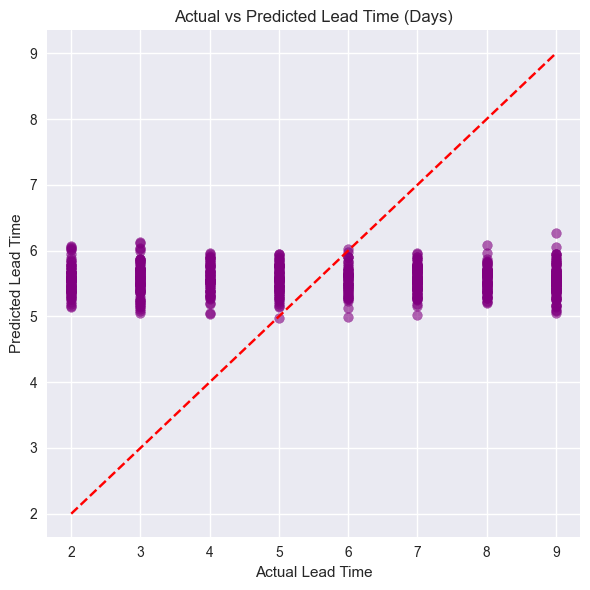

In [39]:
# Actual vs Predicted Plot
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred, alpha=0.6, color="purple")
plt.plot(
    [y_test.min(), y_test.max()],
    [y_test.min(), y_test.max()],
    "r--"
)
plt.title("Actual vs Predicted Lead Time (Days)")
plt.xlabel("Actual Lead Time")
plt.ylabel("Predicted Lead Time")
plt.tight_layout()
plt.savefig("actual_vs_predicted_lead_time.png")
plt.show()


In [40]:
#SOFTWARE / LIBRARY VERSION CHECK 
import sklearn
import sys

print("\nPython version:", sys.version)
print("pandas version:", pd.__version__)
print("numpy version:", np.__version__)
print("seaborn version:", sns.__version__)
print("scikit-learn version:", sklearn.__version__)



Python version: 3.11.0 (main, Oct 24 2022, 18:26:48) [MSC v.1933 64 bit (AMD64)]
pandas version: 2.3.2
numpy version: 2.1.2
seaborn version: 0.13.2
scikit-learn version: 1.7.1
